根据文字影评分析影评的主观性（积极/消极）——二元分类

In [20]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.2.0-rc4


In [0]:
# 下载IMDB数据集
# 数据集已经预处理，单词序列被转化为整数序列，其中每个整数表示字典中的特定单词。

imdb = keras.datasets.imdb
# imdb.load(num_words) num_words参数保留了训练数据中最常见的10,000个单词。
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [22]:
# 数据的格式
print("Train entries: {}, labels: {}".format(len(train_data), len(train_labels)))

print(train_data[0])

Train entries: 25000, labels: 25000
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


既然数据集已经预处理转化为数字，怎么查看数字对应的文本内容呢？

In [0]:
# 将整数转换为数字

# 一个映射单词到整数索引的词典
word_index = imdb.get_word_index()

# 保留第一个索引
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# decode function: input int string return word string.
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [24]:
decode_review(train_data[2])

"<START> this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying into their popcorn that they actually paid money they had <UNK> working to watch this feeble excuse for a film it must have looked like a great idea on paper but on film it looks like no one in the film has a clue what is going on crap acting crap costumes i can't get across how <UNK> this is to watch save yourself an hour a bit of your life"

# 准备数据 （再次预处理） 
之前保存的整数数组，在输入神经网络之前必须转换为tensor,tutorial中提供两种方式：


*   类似one-hot的向量，长度为10,000, 除了包含对应单词的位置为1，其余都为0。这个方法需要大量的内存，矩阵大小 10,000 * num_reviews
*   填充数组，保证输入数据有相同的长度，创建一个大小为max_length * num_reviews 的整型张量。




In [25]:
# 采用填充数组
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

print()

In [26]:
# 采用pad_seuqences 让我产生了一个疑问：
# Q:填充之后的数组，不同instance同一列的数字是否还代表着同一个单词？

# A:首先回答是否定的，不同instance同一列的数字不再代表同一个单词，但是：
# 与one-hot编码不同，one-hot编码是生成all_words 长度的数组，只有0和
# 表示对应的位置有没有，但pad_squences将一个长度为num_samples的2D矩
# 阵转化为(num_samples, maxlen)，且是Numpy，举例：
sequence = [[1],[2,3],[4,5,6]]
tf.keras.preprocessing.sequence.pad_sequences(sequence)

array([[0, 0, 1],
       [0, 2, 3],
       [4, 5, 6]], dtype=int32)

# 构建模型
1. Embedding: 该层采用整数编码的词汇表，查找每个词汇索引的Embedding vector，这些向量是通过模型训练学习得到的。向量向输出数组增加了一个维度，的到的维度为：(batch, sequence,embedding),这里的embedding=16.
2. GlobalAveragePooling1: 通过对序列维度求平均值来为每个样本返回一个fixed-length输出向量。 This allows the model to handle input of variable length, in the simplest way possible.
3. 然后将fixed-length output vector输入到两层全连接网络中。


# 但是Embedding是怎么用的？我还是不太懂。但是Embedding是怎么用的？


In [27]:
# 输入形状不用于训练，用于电影评论的词汇数目
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [0]:
# 选择损失函数，优化器

model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 验证集

在训练时，我们想要检查模型在从未见过的数据上的准确率，因此从原始训练数据中分离出10，000个样本来创建一个验证集。

Q：为什么要有验证集？直接从测试集进行测试，训练集进行训练不可以吗？

A：验证集要满足两件事：1.帮助训练模型 2. 不参与训练。验证集的目标只是使用训练数据来开发和调整模型。
比如，我根据不同参数训练出不同的模型，根据验证集来选出了准确率最高的参数设计。然后再用这个模型去测试（个人理解）。

In [0]:
# 创建一个验证集
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]


In [30]:
# example for train_data[:10000]
list = [1,2,3,4,5,6,7,8,9,0]
list1 = list[5:]
list2 = list[:5]

print(list1,list2)

[6, 7, 8, 9, 0] [1, 2, 3, 4, 5]


# 训练模型

以512个样本的mini-batch大小迭代40个epoch来训练模型。

In [31]:
# parameters:
#   train_data :去除验证集的部分
#   train_label :去除验证集的部分
#   epochs
#   batch_size: mini-batch
#   validataion data: 验证集，上一步刚生成出来
#   verbose: 显示格式
train = model.fit(partial_x_train,
                  partial_y_train,
                  epochs=40,
                  batch_size=512,
                  validation_data=(x_val,y_val),
                  verbose=1
)

Epoch 1/40
30/30 [==============================] - 1s 22ms/step - loss: 0.6919 - accuracy: 0.5951 - val_loss: 0.6898 - val_accuracy: 0.7208
Epoch 2/40
30/30 [==============================] - 1s 19ms/step - loss: 0.6860 - accuracy: 0.6535 - val_loss: 0.6819 - val_accuracy: 0.7337
Epoch 3/40
30/30 [==============================] - 1s 18ms/step - loss: 0.6736 - accuracy: 0.7499 - val_loss: 0.6661 - val_accuracy: 0.7544
Epoch 4/40
30/30 [==============================] - 1s 18ms/step - loss: 0.6509 - accuracy: 0.7769 - val_loss: 0.6397 - val_accuracy: 0.7726
Epoch 5/40
30/30 [==============================] - 1s 18ms/step - loss: 0.6166 - accuracy: 0.7947 - val_loss: 0.6034 - val_accuracy: 0.7881
Epoch 6/40
30/30 [==============================] - 1s 19ms/step - loss: 0.5725 - accuracy: 0.8145 - val_loss: 0.5603 - val_accuracy: 0.8041
Epoch 7/40
30/30 [==============================] - 1s 18ms/step - loss: 0.5229 - accuracy: 0.8320 - val_loss: 0.5141 - val_accuracy: 0.8219
Epoch 8/40
30

# 评估模型
res = model.evaluate(test_data,test_label, verbose=2)

res包含loss 和 accuracy.

In [32]:
res = model.evaluate(test_data, test_labels, verbose=2)
print(res)

782/782 - 1s - loss: 0.3357 - accuracy: 0.8712
[0.3356992304325104, 0.8712000250816345]


# 创建一个accuracy和loss随时间(epochs)变化的图表
model.fit函数返回了一个history对象，（命名为train），该对象包含一个字典，其中包含训练阶段所发生的一切事件：

In [33]:
history_dict = train.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

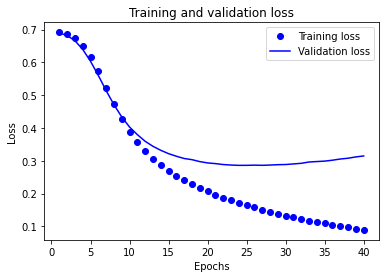

In [34]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

# “bo”代表 "蓝点"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b代表“蓝色实线”
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

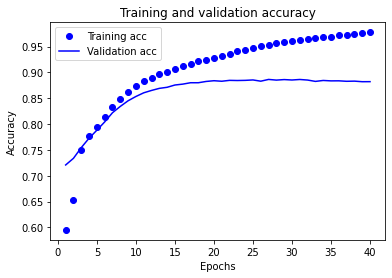

In [35]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Summary:
单从问题来看，这是一个很简单的二分类问题，特别的地方主要在于验证集调用，以及embedding method.